In [1]:
# Importing general libraries
from glob import iglob
import math
import time
import  sys
import difflib

# Import ML related libraries
import tensorflow as tf
import keras
from tensorflow.keras.utils import plot_model
from keras.models import load_model
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras import backend as K
from keras.initializers import glorot_uniform
#from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, confusion_matrix, plot_confusion_matrix
#import lime
#import lime.lime_tabular
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

# Checking the version of the of installed / available libraries
print("Python: " + str(sys.version_info.major) + "." + str(sys.version_info.minor))
print("Tensorflow: " + str(tf.__version__))
print("Keras: " + str(keras.__version__))
print("ScikitLearn: " + str(sklearn.__version__))
print("Pandas: " + str(pd.__version__))
print("NumPy: " + str(np.__version__))

# Fetching the data from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Python: 3.7
Tensorflow: 2.8.0
Keras: 2.8.0
ScikitLearn: 1.0.2
Pandas: 1.3.5
NumPy: 1.21.5
Mounted at /content/drive


In [2]:
# MetaData
#Device_Listing = ['SimpleHome_XCS7_1003_WHT_Security_Camera',  
#                 'SimpleHome_XCS7_1002_WHT_Security_Camera',
#                 'Provision_PT_838_Security_Camera',
#                 'Provision_PT_737E_Security_Camera',
#                 'Danmini_Doorbell',
#                 'Ennio_Doorbell',
#                 'Ecobee_Thermostat',
#                 'Samsung_SNH_1011_N_Webcam',
#                 'Philips_B120N10_Baby_Monitor']

#Malware_Listing = ['Mirai',
#                  'Bashlite']
                 

# Setting Variables


In [3]:
# Environment Variables

Known_Devices = ['192.168.10.50']
Unknown_Devices = ['192.168.10.1']

# At the moment, it is not expected that both of the following booleans shall be true at the same time. Our analysis is for a single malware at a time.
# Run_For_Malware_Mirai = 0
# Run_For_Malware_Bashlite = 1

# Fisher Score Variables
fisher_score_use_top_n_features = 85 #(max value is 115, reducing this value will reduce the total pool of features to use in training)
use_features_with_fisher_score_greater_than = 0.1 #(when set to 0, will use all top_n features allowed in above variable. For none zero values, will only use features from the top_n variable above
                                                # whose fisher score is greater than the value set in this variable.)

# This name shall be used to generate relevant save file names at relevant paths
savefilename='KNOWN-DEVICE'
transfer_savefilename='TRANSFER-DEVICE'

checkpoint_filepath=f"/content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/{savefilename}-{use_features_with_fisher_score_greater_than}.h5"
transfer_learning_checkpoint_filepath=f"/content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/{transfer_savefilename}-{use_features_with_fisher_score_greater_than}.h5"
Known_F_Score_File=f"/content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017G/Fisher-Scores/{savefilename}-A-{use_features_with_fisher_score_greater_than}.csv"
Unknown_F_Score_File=f"/content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/Fisher-Scores/{savefilename}-B-{use_features_with_fisher_score_greater_than}.csv"



**First, we shall do all of our work related to the Known device and then proceed towards the unknown devices**

**Collecting Data for the Known Devices. Both Benign and Attack data shall be included.**

In [4]:
print("====-- Loading Benign Data --====\n")

filepaths = []
for device in Known_Devices:
  print(device)
  path = f"/content/drive/My Drive/thesis-unsub/data-PerIPData/{device}/benign/monday-benign-data.csv"
  filepaths.append(path)

df_known_device_benign = pd.concat((pd.read_csv(f, header=None, index_col=0) for f in filepaths), ignore_index=True)
print("\n Benign DataFrame Information\n------")
#df_known_device_benign.info()
df_known_device_benign = df_known_device_benign.loc[:,7:83]
df_known_device_benign.astype(float)
df_known_device_benign.replace([np.inf, -np.inf], np.nan, inplace=True)
df_known_device_benign.fillna(0, inplace=True)

print(df_known_device_benign)


print("\n\n=========\n\n")


print("====-- Loading Attack Data ---====\n")
print("====-- Separate Attack Dataframes shall be created --====")
attack_filepaths = []
for device in Known_Devices:
  print(device)
  #attackpath = f"/content/drive/My Drive/thesis-unsub/data-PerIPData/{device}/attack/attack-aggregated.csv"
  #attackpath = f"/content/drive/My Drive/thesis-unsub/data-PerIPData/{device}/attack/DDoS/attack.csv"
  #attackpath = f"/content/drive/My Drive/thesis-unsub/data-PerIPData/{device}/attack/DoS-GoldenEye/attack.csv"
  #attackpath = f"/content/drive/My Drive/thesis-unsub/data-PerIPData/{device}/attack/DoS-Hulk/attack.csv"
  #attackpath = f"/content/drive/My Drive/thesis-unsub/data-PerIPData/{device}/attack/DoS-Slowhttptest/attack.csv"
  #attackpath = f"/content/drive/My Drive/thesis-unsub/data-PerIPData/{device}/attack/DoS-slowloris/attack.csv"
  #attackpath = f"/content/drive/My Drive/thesis-unsub/data-PerIPData/{device}/attack/FTP-Patator/attack.csv"
  #attackpath = f"/content/drive/My Drive/thesis-unsub/data-PerIPData/{device}/attack/SSH-Patator/attack.csv"
  #attackpath = f"/content/drive/My Drive/thesis-unsub/data-PerIPData/{device}/attack/PortScan/attack.csv"
  #attackpath = f"/content/drive/My Drive/thesis-unsub/data-PerIPData/{device}/attack/Web-Attack-Brute-Force/attack.csv"
  #attackpath = f"/content/drive/My Drive/thesis-unsub/data-PerIPData/{device}/attack/Web-Attack-Sql-Injection/attack.csv"
  attackpath = f"/content/drive/My Drive/thesis-unsub/data-PerIPData/{device}/attack/Web-Attack-XSS/attack.csv"
  attack_filepaths.append(attackpath)

print(attack_filepaths)

df_known_device_attack= pd.concat((pd.read_csv(f, header=None, index_col=0) for f in attack_filepaths), ignore_index=True)
print("\n Aggregated Attack Dataframe \n------")
df_known_device_attack = df_known_device_attack.loc[:,7:83]
df_known_device_attack.astype(float)
df_known_device_attack.replace([np.inf, -np.inf], np.nan, inplace=True)
df_known_device_attack.fillna(0, inplace=True)
print(df_known_device_attack)
#df_known_device_attack.info()


====-- Loading Benign Data --====

192.168.10.50

 Benign DataFrame Information
------
          7   8   9     10    11    12  13  ...   77  78  79   80   81  82  83
0        625  11   4   172   326    79   0  ...  0.0   0   0  0.0  0.0   0   0
1       1155   9   6  3226  3232  1613   0  ...  0.0   0   0  0.0  0.0   0   0
2        457  11   4   172   326    79   0  ...  0.0   0   0  0.0  0.0   0   0
3       1175   9   6  3226  3232  1613   0  ...  0.0   0   0  0.0  0.0   0   0
4      54462  11   6  2868  2790  1430   0  ...  0.0   0   0  0.0  0.0   0   0
...      ...  ..  ..   ...   ...   ...  ..  ...  ...  ..  ..  ...  ...  ..  ..
11335     19  13   0   481     0    37  37  ...  0.0   0   0  0.0  0.0   0   0
11336     49   1   2     6    12     6   6  ...  0.0   0   0  0.0  0.0   0   0
11337    159   2   2    88   188    44  44  ...  0.0   0   0  0.0  0.0   0   0
11338     78   1   2     0     0     0   0  ...  0.0   0   0  0.0  0.0   0   0
11339    157   2   2    88   188    44  44  

In [5]:
## Validating NULL fields
np.where(pd.isnull(df_known_device_benign))
np.any(np.isnan(df_known_device_benign))
np.all(np.isfinite(df_known_device_benign))

True

In [6]:
#print("Randomly selecting 10% of the benign data")
#df_known_device_benign_frac = df_known_device_benign.sample(frac=0.1)

print("Splitting Benign Data into 3 parts for training, optimization and test in a 60/20/20 split")
#df_benign_train, df_benign_opt, df_benign_test = np.split(df_benign.sample(frac=1, random_state=406), [int(1/3*len(df_benign)), int(2/3*len(df_benign))])
#df_known_device_benign_train, df_known_device_benign_opt, df_known_device_benign_test = np.split(df_known_device_benign.sample(frac=1, random_state=406), [int(3/5*len(df_known_device_benign)), int(4/5*len(df_known_device_benign))])

#df_known_device_benign_train, df_known_device_benign_opt, df_known_device_benign_test = np.split(df_known_device_benign_frac.sample(frac=1), [int(3/5*len(df_known_device_benign_frac)), int(4/5*len(df_known_device_benign_frac))])
df_known_device_benign_train, df_known_device_benign_opt, df_known_device_benign_test = np.split(df_known_device_benign.sample(frac=1), [int(3/5*len(df_known_device_benign)), int(4/5*len(df_known_device_benign))])

print("Split Information")
print("df_known_device_benign_train: " + str(df_known_device_benign_train.shape))
print("df_known_device_benign_opt:   " + str(df_known_device_benign_opt.shape))
print("df_known_device_benign_test:  " + str(df_known_device_benign_test.shape))
print("\n")

print("Information about the Split\nTraining Data\n---")
#df_known_device_benign_train.info()
print(df_known_device_benign_train)

print("\nOptimization Data\n---")
#df_known_device_benign_opt.info()
print(df_known_device_benign_opt)

print("\nTest Data\n---")
#df_known_device_benign_test.info()
print(df_known_device_benign_test)

Splitting Benign Data into 3 parts for training, optimization and test in a 60/20/20 split
Split Information
df_known_device_benign_train: (6804, 77)
df_known_device_benign_opt:   (2268, 77)
df_known_device_benign_test:  (2268, 77)


Information about the Split
Training Data
---
              7   8   9     10  ...          80            81        82        83
8792         234   2   2    64  ...         0.0  0.000000e+00         0         0
3817   109080349  28  14  5642  ...  35206659.0  4.908431e+06  38149437  29540304
6744         191   2   2    88  ...         0.0  0.000000e+00         0         0
2726           2   2   0   617  ...         0.0  0.000000e+00         0         0
9368          79   1   4     0  ...         0.0  0.000000e+00         0         0
...          ...  ..  ..   ...  ...         ...           ...       ...       ...
10487         66   1   2     6  ...         0.0  0.000000e+00         0         0
7757         108   1   4     0  ...         0.0  0.000000e+00   

**Scaling the Bengin (train, opt, test) and the attack datasets**

In [7]:
# Extracting the column names from our dataset for use later,

'''
 col_list = []
 for col in df_known_device_benign_train.columns:
  col_list.append(col)

 print(col_list)
 '''

# Implementing the Normalization, We fit normalization parameters on the train dataset and use them to scale the opt, test and attack datasets.
scaler = MinMaxScaler()

scaled_df_known_device_benign_train = scaler.fit_transform(df_known_device_benign_train)
scaled_df_known_device_benign_opt = scaler.transform(df_known_device_benign_opt)
scaled_df_known_device_benign_test = scaler.transform(df_known_device_benign_test)

scaled_df_known_device_attack = scaler.transform(df_known_device_attack)


#Converting NumPy arrays back to Pandas DataFrames
scaled_df_known_device_benign_train = pd.DataFrame(scaled_df_known_device_benign_train)
scaled_df_known_device_benign_opt = pd.DataFrame(scaled_df_known_device_benign_opt)
scaled_df_known_device_benign_test = pd.DataFrame(scaled_df_known_device_benign_test)

scaled_df_known_device_attack = pd.DataFrame(scaled_df_known_device_attack)



Adding labels to the dataframes

In [8]:
scaled_df_known_device_attack['class'] = 'attack'
scaled_df_known_device_benign_train['class'] = 'benign'
scaled_df_known_device_benign_opt['class'] = 'benign'
scaled_df_known_device_benign_test['class'] = 'benign'

**Time to calculate the Fisher Score and identify the most valuable features from the known devices benign and attack datasets**


In [9]:
'''

## Fisher Scoring, for Fisher scoring we shall use the attack data of the same devices
## for which we trained our benign model.

# Creating a Fisher dataframe that shall contain an equal mix of benign_train and attack data.
# Removing randomizing states. We shall have multiple runs and tabulation of results.
# scaled_df_fisher = scaled_df_known_device_benign_train.append(scaled_df_known_device_attack.sample(n=scaled_df_known_device_benign_train.shape[0], random_state=406))
scaled_df_fisher = scaled_df_known_device_benign_train.append(scaled_df_known_device_attack.sample(n=scaled_df_known_device_benign_train.shape[0]))

print(scaled_df_fisher.shape)
scored = [] # declare a list
indices = {} # declare two dictionaries, purpose unknown
shps = {}
classes = ['benign','attack']

for cl in classes:
    indices[cl] = scaled_df_fisher['class'] == cl # Now here, above created Fisher dataframe shall have two classes only.
                                           # so half of the time the comparison output shall be true and false
                                           # for the rest.
                                           # It creates a Pandas series
    shps[cl] = scaled_df_fisher[indices[cl]].shape[0] # dictionary contains the number of rows of benign traffic and the
                                               # number of rows for the attack traffic

for col in scaled_df_fisher.columns: # Loop through all the columns of the Fisher DataFrame
    if col == 'class':  # if the column is that of "Class", then skip it.
        continue
    num = 0
    den = 0
    m = scaled_df_fisher[col].mean() # For the column under the current iteration, find the mean value.
                            # no, nothing strange about this. We are finding out the mean of each field/column
                            # in the dataset.
    
    for cl in classes: # For each column (this essentially means that we are considering that column at the moment)
                       # calculate the numerator and the denominator values for the Fisher score per class.
        num += (shps[cl] / scaled_df_fisher.shape[0]) * (m - scaled_df_fisher[indices[cl]][col].mean())**2
                # shps[cl] --> e.g if shps['benign'] then number of rows in it shall be 33032
                # (33032/66064) * ([mean-of-that-whole-column] - mean-of-rows-whose class was cl)**2
        den += (shps[cl] / scaled_df_fisher.shape[0]) * scaled_df_fisher[indices[cl]][col].var()
                # shps[cl] --> e.g if shps['benign'] then number of rows in it shall be 33032
                # (33032/66064) * (variance-of-rows-whose class was cl)
        
    score = {'feature': col, 'score': num / den}
    scored.append(score)
    #print(score)
scored.sort(key=lambda x: x['score'], reverse=True)
scored[:115] #scored is a list of dictionaries    


# Write down the calculated F-scores in a file.
with open(Known_F_Score_File, 'w+') as file:
    lines = ['Feature,Score\n']
    for s in scored:
        lines.append(s['feature'] + ',' + "{0:.2f}".format(s['score']) + '\n')
    file.writelines(lines)

lines

'''

'\n\n## Fisher Scoring, for Fisher scoring we shall use the attack data of the same devices\n## for which we trained our benign model.\n\n# Creating a Fisher dataframe that shall contain an equal mix of benign_train and attack data.\n# Removing randomizing states. We shall have multiple runs and tabulation of results.\n# scaled_df_fisher = scaled_df_known_device_benign_train.append(scaled_df_known_device_attack.sample(n=scaled_df_known_device_benign_train.shape[0], random_state=406))\nscaled_df_fisher = scaled_df_known_device_benign_train.append(scaled_df_known_device_attack.sample(n=scaled_df_known_device_benign_train.shape[0]))\n\nprint(scaled_df_fisher.shape)\nscored = [] # declare a list\nindices = {} # declare two dictionaries, purpose unknown\nshps = {}\nclasses = [\'benign\',\'attack\']\n\nfor cl in classes:\n    indices[cl] = scaled_df_fisher[\'class\'] == cl # Now here, above created Fisher dataframe shall have two classes only.\n                                           # so

**Model Training**

In [10]:
# Now creating a ____________ model
def create_model(input_dim):
    inp = Input(shape=(input_dim,))
    encoder = Dense(int(math.ceil(0.80 * input_dim)), activation="tanh")(inp)
    encoder = Dense(int(math.ceil(0.60 * input_dim)), activation="tanh")(encoder)
    encoder = Dense(int(math.ceil(0.40 * input_dim)), activation="tanh")(encoder)
    encoder = Dense(int(math.ceil(0.20 * input_dim)), activation="tanh")(encoder)
    decoder = Dense(int(math.ceil(0.40 * input_dim)), activation="tanh")(encoder)
    decoder = Dense(int(math.ceil(0.60 * input_dim)), activation="tanh")(decoder)
    decoder = Dense(int(math.ceil(0.80 * input_dim)), activation="tanh")(decoder)
    decoder = Dense(input_dim)(decoder)
    return Model(inp, decoder)

In [11]:
'''
for top_n_features in [fisher_score_use_top_n_features]: # for loop runs only once. because there is a single item in the list only. The number
                           # describes the number of top features that shall be selected 
    #fs = [it['feature'] for it in scored[:top_n_features]] # fs is a list of feature names in order of decreasing
                                                           # F-score
    
    fs = []
    for it in scored[:top_n_features]:
      if it['score'] > use_features_with_fisher_score_greater_than:  
        fs.append(it['feature'])

    features_to_be_used = len(fs)
    print(features_to_be_used)
    #print(scored[:top_n_features])
    #print(fs)
    #print(type(fs))
'''

DF_BENIGN_TRAIN = scaled_df_known_device_benign_train.iloc[:,:-1]
DF_BENIGN_OPT = scaled_df_known_device_benign_opt.iloc[:,:-1]
DF_BENIGN_TEST = scaled_df_known_device_benign_test.iloc[:,:-1]

print(type(DF_BENIGN_TRAIN))
print(DF_BENIGN_TRAIN)

fs = DF_BENIGN_TRAIN.shape[1]
print("fs: " + str(fs))

model = create_model(fs)
model.compile(loss="mean_squared_error", optimizer="adam")
    
Initial_Weights = model.get_weights()
    
cp = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', save_best_only=True, verbose=1)
    
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()
epochs = 100
history = model.fit(DF_BENIGN_TRAIN, DF_BENIGN_TRAIN, epochs=epochs, validation_data=(DF_BENIGN_OPT, DF_BENIGN_OPT), verbose=1, callbacks=[cp, es])
    
end = time.time()
print('time')
print(end - start)
print(model.summary())

## till here, we have created a model using X number of top features


<class 'pandas.core.frame.DataFrame'>
                0         1         2   ...        74        75        76
0     1.953607e-06  0.002660  0.019802  ...  0.000000  0.000000  0.000000
1     9.106843e-01  0.071809  0.138614  ...  0.065626  0.340303  0.275287
2     1.594611e-06  0.002660  0.019802  ...  0.000000  0.000000  0.000000
3     1.669750e-08  0.002660  0.000000  ...  0.000000  0.000000  0.000000
4     6.595511e-07  0.000000  0.039604  ...  0.000000  0.000000  0.000000
...            ...       ...       ...  ...       ...       ...       ...
6799  5.510174e-07  0.000000  0.019802  ...  0.000000  0.000000  0.000000
6800  9.016648e-07  0.000000  0.039604  ...  0.000000  0.000000  0.000000
6801  1.461031e-06  0.002660  0.019802  ...  0.000000  0.000000  0.000000
6802  1.197225e-02  0.101064  0.415842  ...  0.000000  0.000000  0.000000
6803  1.394241e-06  0.000000  0.009901  ...  0.000000  0.000000  0.000000

[6804 rows x 77 columns]
fs: 77
Epoch 1/100
207/213 [====================

Plotting the Training and Validation curves


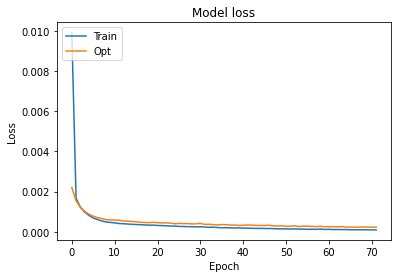

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Opt'], loc='upper left')
plt.show()

**Defining an Error Threshold**

In [13]:
# above cell has successfully trained our model.
# 80% of the benign dataset has been consumed for training and validating the anomaly model.

# We shall use the remaining the 20% of the benign dataset to make an estimation of the reconstruction error of our autoencoder.

# Additionally, we shall only consume the feature columns which were used for the training.


df_benign_known_device_test_predictions = model.predict(scaled_df_known_device_benign_test.iloc[:,:-1])

#print(df_benign_test_predictions)
# how can we substract a series from a dataframe?
#print("Type of the variable DF_BENIGN_TEST: " + str(type(DF_BENIGN_TEST)))
#print("Type of the variable DF_BENIGN_TEST_PREDICTIONS: " + str(type(df_benign_test_predictions)))
print("Shape of variable DF_BENIGN_TEST: " + str(scaled_df_known_device_benign_test.iloc[:,:-1].shape))
print("Shape of variable DF_BENIGN_TEST_PREDICTIONS: " + str(df_benign_known_device_test_predictions.shape))
difference = scaled_df_known_device_benign_test.iloc[:,:-1] - df_benign_known_device_test_predictions
print("Shape of the variable difference: " + str(difference.shape))

mse = np.mean(np.power(scaled_df_known_device_benign_test.iloc[:,:-1] - df_benign_known_device_test_predictions, 2), axis=1) # Mean-Squared-Error is calculated for each row,
                                                                                # all ten feature values are used to generate a single error
                                                                                # number.
#print(type(mse))
#print("Shape of Mean-Squared-Error: " + str(mse.shape))
mean = mse.mean() # We calculate the mean of the whole series, that is the mean mse for all the benign test cases.
std = mse.std() # And we calculate the standard deviation of the mse series, containing only the test cases.

mse = pd.Series(mse)
print("MSE TYPE:    " + str(type(mse)))
print("MIN of MSE: " + str(mse.min()))
print("MAX of MSE: " + str(mse.max()))
print("MEAN of MSE: " + str(mean))
print("STD of MSE:  " + str(std))

mse_min = mse.min()
mse_max = mse.max()
print("\nMax Threshold = MSE_MAX: " + str(mse_max))

max_std_multiplier = int((mse_max - mean) / std)
print("\nMAX_STD_Multiplier = " + str(max_std_multiplier))
 

Shape of variable DF_BENIGN_TEST: (2268, 77)
Shape of variable DF_BENIGN_TEST_PREDICTIONS: (2268, 77)
Shape of the variable difference: (2268, 77)
MSE TYPE:    <class 'pandas.core.series.Series'>
MIN of MSE: 1.4351869984937955e-05
MAX of MSE: 1122.76858356757
MEAN of MSE: 0.9904200476342718
STD of MSE:  33.33384894834578

Max Threshold = MSE_MAX: 1122.76858356757

MAX_STD_Multiplier = 33


**Visualizing the error distribution of the test dataset**

(0.0, 2268.0)

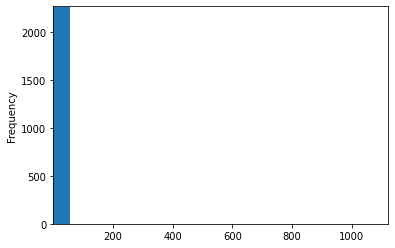

In [14]:
mse_plot = mse.plot.hist(bins=20)
mse_plot.set_xlim((mse_min, mse_max))
mse_plot.set_ylim((0, mse[mse <= mse_max].count()))

MIN of QUANTILE_MSE: 1.4351869984937955e-05
MAX of QUANTILE_MSE: 1122.76858356757
MEAN of QUANTILE_MSE: 0.9904200476342718
STD of QUNATILE_MSE:  33.33384894834578
Size of Series below 95th quantile: 2268

Suggested Minimum Threshold = QUANTILE_MSE_MAX: 1122.76858356757

MIN_STD_Multiplier = 33
2268
2268


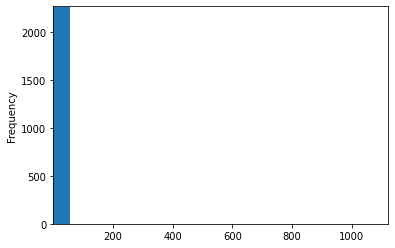

In [15]:
# Identifying a quantile distribution on the basis that the records of large MSE maybe an anomaly.
# We postulate that records with MSE residing above the 95th percentile may be erroneous
# Attempting to find the STD Multiplier corresponding to the 95th percentile
#Anomaly Threshold percentile                                                
test_percentile = 1

quantile_mse = mse[mse <= mse.quantile(q=test_percentile)]  # <= is important here

print("MIN of QUANTILE_MSE: " + str(quantile_mse.min()))
print("MAX of QUANTILE_MSE: " + str(quantile_mse.max()))
print("MEAN of QUANTILE_MSE: " + str(quantile_mse.mean()))
print("STD of QUNATILE_MSE:  " + str(quantile_mse.std()))

print("Size of Series below 95th quantile: " + str(quantile_mse.size))

print("\nSuggested Minimum Threshold = QUANTILE_MSE_MAX: " + str(quantile_mse.max()))

min_std_multiplier = int((quantile_mse.max() - quantile_mse.mean()) / quantile_mse.std())
print("\nMIN_STD_Multiplier = " + str(min_std_multiplier))


quantile_mse_plot = quantile_mse.plot.hist(bins=20)
quantile_mse_plot.set_xlim((quantile_mse.min(), quantile_mse.max()))
quantile_mse_plot.set_ylim((0, quantile_mse[quantile_mse <= quantile_mse.max()].count()))

print(len(mse))
print(len(quantile_mse))

**Now lets evaluate the anomaly detection capability of this model on the known_device's own attack dataset**

In [16]:
 #A Class definition for executing predictions
class AnomalyModel:
    def __init__(self, model, threshold, scaler):
        self.model = model
        self.threshold = threshold
        self.scaler = scaler

    def predict(self, x):
        x_pred = self.model.predict(x)
        mse = np.mean(np.power(x - x_pred, 2), axis=1)
        y_pred = mse > self.threshold
        return y_pred.astype(int)

    #def scale_predict_classes(self, x):
    #    x = self.scaler.transform(x)
    #    y_pred = self.predict(x)
    #    classes_arr = []
    #    for e in y_pred:
    #        el = [0,0]
    #        el[e] = 1
    #        classes_arr.append(el)
    #    return np.array(classes_arr)

Test-----------------
Accuracy
0.5
Precision
0.0
CM
[[652   0]
 [652   0]]
<class 'numpy.ndarray'>


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


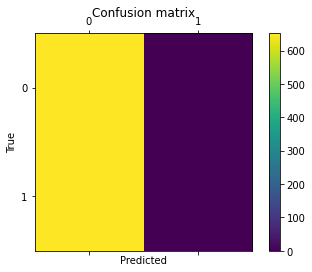

Test-----------------
Accuracy
0.5
Precision
0.0
CM
[[652   0]
 [652   0]]
<class 'numpy.ndarray'>


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


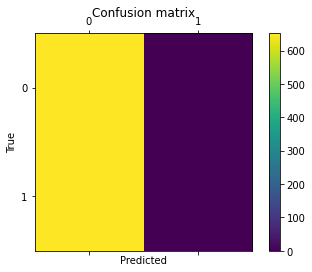

In [17]:
# Testing the accuracy of the anomaly model on the known_devices attack data

# While we have used the benign_test dataset to define a threshold, its unknown to the model itself since no parameters learnt have used values from this dataset.
# We shall thus use a random mix of benign_test dataset and the attack_dataset for our testing.

rows_in_attack = scaled_df_known_device_attack.shape[0]
rows_in_benign_test = scaled_df_known_device_benign_test.shape[0]

# Removing randomness bias
# df_malicious = df_known_device_attack.sample(n=df_known_device_benign_test.shape[0], random_state=406)[fs] # Keeping equal parts of benign / malicious data


if int(rows_in_benign_test) < int(rows_in_attack):
  anomaly_detect_01_df_benign = scaled_df_known_device_benign_test.iloc[:,:-1] # Creating Labeled datasets
  anomaly_detect_01_df_benign['malicious'] = 0
  anomaly_detect_01_df_malicious = scaled_df_known_device_attack.sample(n=scaled_df_known_device_benign_test.shape[0]).iloc[:,:-1] # Keeping equal parts of benign / malicious data
  anomaly_detect_01_df_malicious['malicious'] = 1

if int(rows_in_benign_test) > int(rows_in_attack):
  anomaly_detect_01_df_malicious = scaled_df_known_device_attack.iloc[:,:-1]
  anomaly_detect_01_df_malicious['malicious'] = 1
  anomaly_detect_01_df_benign = scaled_df_known_device_benign_test.sample(n=scaled_df_known_device_attack.shape[0]).iloc[:,:-1]
  anomaly_detect_01_df_benign['malicious'] = 0


anomaly_detect_01_df = anomaly_detect_01_df_benign.append(anomaly_detect_01_df_malicious)
anomaly_detect_01_X_test = anomaly_detect_01_df.drop(columns=['malicious']).values
anomaly_detect_01_Y_test = anomaly_detect_01_df['malicious'] # This shall form the ground truth series of values.
#print(Y_test)

for threshold in [mse_max, quantile_mse.max()]:
  m = AnomalyModel(model , threshold, scaler)
  anomaly_detect_01_Y_pred = m.predict(anomaly_detect_01_X_test)
  print('Test-----------------')
  #print(f'suggensted threshodl n {best_n}')
  print('Accuracy')
  anomaly_detect_01_acc = accuracy_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
  print(anomaly_detect_01_acc)
  print('Precision')
  anomaly_detect_01_prec = precision_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
  print(anomaly_detect_01_prec)
  print('CM')
  anomaly_detect_01_cm = confusion_matrix(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred, labels=[0,1])
  print(anomaly_detect_01_cm)  
  print(type(anomaly_detect_01_cm)) 
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(anomaly_detect_01_cm)
  plt.title('Confusion matrix')
  fig.colorbar(cax)
  labels=['0','1']
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()


**Finding an anomaly threshold that maximises the accuracy and precision of the model**


Starting Accuracy
Starting Precision
0.0
Iterating through percentiles to find best threshold

Current Percentile: 0.995

Current Threshold: 0.006088006969135527

 new_acc: 0.5130368098159509 ... new_precision: 0.9047619047619048

 new_acc > best_acc 


Iterating through percentiles to find best threshold

Current Percentile: 0.99

Current Threshold: 0.0016513004771294974

 new_acc: 0.9739263803680982 ... new_precision: 0.9889240506329114

 new_acc > best_acc 


Iterating through percentiles to find best threshold

Current Percentile: 0.985

Current Threshold: 0.0011532238453294172

 new_acc: 0.973159509202454 ... new_precision: 0.9843014128728415

 NEW_ACC <= BEST_ACC 


Iterating through percentiles to find best threshold

Current Percentile: 0.98

Current Threshold: 0.0007758004830406612

 new_acc: 0.9693251533742331 ... new_precision: 0.9751552795031055

 NEW_ACC <= BEST_ACC 


Iterating through percentiles to find best threshold

Current Percentile: 0.975

Current Threshold: 0.000

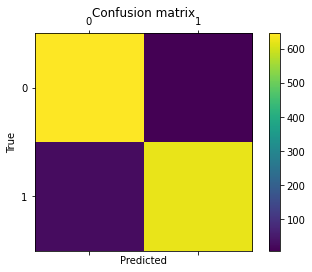

In [18]:
print('Starting Accuracy')
starting_accuracy = anomaly_detect_01_acc
best_acc = starting_accuracy
print('Starting Precision')
base_precision = anomaly_detect_01_prec
print(base_precision)

new_percentile = 0.995
#new_percentile = new_percentile - 0.005
some_increase_found = False

for test_percentile in [0.995, 0.99, 0.985, 0.98, 0.975, 0.97, 0.965, 0.96, 0.955, 0.95, 0.945, 0.94, 0.935, 0.93, 0.925, 0.92, 0.915, 0.91, 0.905, 0.90]:
  print("Iterating through percentiles to find best threshold")

  threshold = mse[mse < mse.quantile(q=test_percentile)].max()
  print(str('\nCurrent Percentile: ' + str(test_percentile)))
  print(str('\nCurrent Threshold: ' + str(threshold)))
  m = AnomalyModel(model, threshold, scaler)
  anomaly_detect_01_Y_pred = m.predict(anomaly_detect_01_X_test)
  new_acc = accuracy_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
  new_precision = precision_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
  print(str('\n new_acc: ' + str(new_acc) + ' ... new_precision: ' + str(new_precision)))
  if new_acc > best_acc:
    print('\n new_acc > best_acc \n\n') 
    best_acc = new_acc
    best_percentile = test_percentile
  else:
    print('\n NEW_ACC <= BEST_ACC \n\n')


if new_acc > starting_accuracy:
  print('==== ITERATION DONE ======')

  threshold = mse[mse < mse.quantile(q=best_percentile)].max()
  #results_file_writing(str('\nCurrent Threshold: ' + str(threshold)))
  m = AnomalyModel(model, threshold, scaler)
  anomaly_detect_01_Y_pred = m.predict(anomaly_detect_01_X_test)  
  
  anomaly_detect_01_cm = confusion_matrix(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred, labels=[0,1])

  print("Accuracy: " + str(accuracy_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)))
  print("Precision: " + str(precision_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)))
  print("Recall: " + str(recall_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)))
  print("F1_score: " + str(f1_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)))
  
  print('CM')
  print(anomaly_detect_01_cm)  
  print(type(anomaly_detect_01_cm)) 
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(anomaly_detect_01_cm)
  plt.title('Confusion matrix')
  fig.colorbar(cax)
  labels=['0','1']
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()
else:
  anomaly_detect_01_chosen_threshold = mse_max
  print("Chosen Threshold: " + str(anomaly_detect_01_chosen_threshold))
  print("This is MSE MAX")
  anomaly_detect_01_cm = confusion_matrix(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred, labels=[0,1])
  
  m = AnomalyModel(model, anomaly_detect_01_chosen_threshold, scaler)
  anomaly_detect_01_Y_pred = m.predict(anomaly_detect_01_X_test)  

  print("Accuracy: " + str(accuracy_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)))
  print("Precision: " + str(precision_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)))
  print("Recall: " + str(recall_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)))
  print("F1_score: " + str(f1_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)))
  
  print('CM')
  print(anomaly_detect_01_cm)  
  print(type(anomaly_detect_01_cm)) 
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(anomaly_detect_01_cm)
  plt.title('Confusion matrix')
  fig.colorbar(cax)
  labels=['0','1']
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()


# Now that we have a model of a known device, lets test it against an unknown device.

In order to find the accuracy and precision of the data, we shall need both the benign and the malicious data, scaled to the originally learnt parameters.

In [19]:
#Run_For_Malware_Mirai = 0
#Run_For_Malware_Bashlite = 1

In [20]:
print("====-- Loading Benign Data --====\n")

filepaths = []
for device in Unknown_Devices:
  print(device)
  path = f"/content/drive/My Drive/thesis-unsub/data/{device}/benign_traffic.csv"
  filepaths.append(path)

df_unknown_device_benign = pd.concat((pd.read_csv(f) for f in filepaths), ignore_index=True)
print("\n Benign DataFrame Information\n------")
df_unknown_device_benign.info()


print("\n\n=========\n\n")


if Run_For_Malware_Mirai:
  print("====-- Loading Attack Data - Mirai --====\n")
  Mirai_Filepaths = []
  for device in Unknown_Devices:
    print(device)
    path = f"/content/drive/My Drive/thesis-unsub/data/{device}/mirai_attacks/"
    for files in ['ack.csv', 'scan.csv', 'syn.csv', 'udp.csv', 'udpplain.csv']:
      filepath = path + str(files)
      Mirai_Filepaths.append(filepath)

  print(Mirai_Filepaths)

  df_unknown_device_attack= pd.concat((pd.read_csv(f) for f in Mirai_Filepaths), ignore_index=True)
  print("\n Malware DataFrame Information - Mirai\n------")
  df_unknown_device_attack.info()



if Run_For_Malware_Bashlite:
  Bashlite_Filepaths = []
  for device in Unknown_Devices:
    print(device)
    path = f"/content/drive/My Drive/thesis-unsub/data/{device}/gafgyt_attacks/"
    for files in ['combo.csv', 'junk.csv', 'scan.csv', 'tcp.csv', 'udp.csv']:
      filepath = path + str(files)
      Bashlite_Filepaths.append(filepath)

  print(Bashlite_Filepaths)

  df_unknown_device_attack = pd.concat((pd.read_csv(f) for f in Bashlite_Filepaths), ignore_index=True)
  print("\nDataFrame Information\n------")
  df_unknown_device_attack.info()


====-- Loading Benign Data --====

192.168.10.1


FileNotFoundError: ignored

Scaling unknown devices data.

In [ ]:
# Scaling the unknown devices data to the parameters learnt during the scaling of the known devices data.

scaled_df_unknown_device_benign = scaler.transform(df_unknown_device_benign)
scaled_df_unknown_device_attack = scaler.transform(df_unknown_device_attack)


#Converting NumPy arrays back to Pandas DataFrames
scaled_df_unknown_device_benign = pd.DataFrame(scaled_df_unknown_device_benign, columns=col_list)
scaled_df_unknown_device_attack = pd.DataFrame(scaled_df_unknown_device_attack, columns=col_list)


In [ ]:
scaled_df_unknown_device_attack['class'] = 'attack'
scaled_df_unknown_device_benign['class'] = 'benign'

**Now we need to simulate some observed behavior and some unknown behavior of benign data.**

observed behavior is that small sample that we shall use for transfer learning.

unknown behavior is that sample used to check accuracy of the model.

In [ ]:
# sampling some data from the dataset. We shall sample this data to check if it improves the autoencoder accuracy.
# and splitting this data into three parts, for training, optimization and validation.

length_unknown_device_benign = len(scaled_df_unknown_device_benign)

# extracting a small sample for re-training the model
scaled_df_unknown_device_benign_sample, scaled_df_unknown_device_benign_remaining = np.split(scaled_df_unknown_device_benign.sample(frac=1), [int(0.10*length_unknown_device_benign)])


# splitting the small sample of data into train, opt and test datasets.
scaled_df_unknown_device_benign_sample_train, scaled_df_unknown_device_benign_sample_opt, scaled_df_unknown_device_benign_sample_test = np.split(scaled_df_unknown_device_benign_sample, [int(3/5*len(scaled_df_unknown_device_benign_sample)), int(4/5*len(scaled_df_unknown_device_benign_sample))])


print("INFORMATION ON SAMPLED DATA")
scaled_df_unknown_device_benign_sample.info()

print("\nINFORMATION ON REMAINING BENIGN DATA")
scaled_df_unknown_device_benign_remaining.info()

print("\nSAMPLE DATA SPLIT FOR TRAIN, OPT AND TEST")
scaled_df_unknown_device_benign_sample_train.info()
scaled_df_unknown_device_benign_sample_opt.info()
scaled_df_unknown_device_benign_sample_test.info()


**Time to calculate the Fisher Score, Hope to use this to build a picture on the difference in important features**

Here we shall us only use the sampled data for fisher score calculation, since this is the only known informaiton.

I did not observe much difference in the Fisher scores when comparing the use of a whole dataset or only the sampled dataset.

In [ ]:
## Fisher Scoring, for Fisher scoring we shall use the attack data of the same devices
## for which we trained our benign model.

# Creating a Fisher dataframe that shall contain an equal mix of benign_train and attack data.
# Removing randomizing states. We shall have multiple runs and tabulation of results.
# scaled_df_fisher = scaled_df_known_device_benign_train.append(scaled_df_known_device_attack.sample(n=scaled_df_known_device_benign_train.shape[0], random_state=406))

# Using the whole dataset.
#unknown_scaled_df_fisher = scaled_df_unknown_device_benign.append(scaled_df_unknown_device_attack.sample(n=scaled_df_unknown_device_benign.shape[0]))

# Using only the sampled dataset.
unknown_scaled_df_fisher = scaled_df_unknown_device_benign_sample.append(scaled_df_unknown_device_attack.sample(n=scaled_df_unknown_device_benign_sample.shape[0]))

unknown_scaled_df_fisher.info()

unknown_scored = [] # declare a list
unknown_indices = {} # declare two dictionaries, purpose unknown
unknown_shps = {}
unknown_classes = ['benign','attack']

for cl in unknown_classes:
    unknown_indices[cl] = unknown_scaled_df_fisher['class'] == cl # Now here, above created Fisher dataframe shall have two classes only.
                                           # so half of the time the comparison output shall be true and false
                                           # for the rest.
                                           # It creates a Pandas series
    unknown_shps[cl] = unknown_scaled_df_fisher[unknown_indices[cl]].shape[0] # dictionary contains the number of rows of benign traffic and the
                                               # number of rows for the attack traffic

for col in unknown_scaled_df_fisher.columns: # Loop through all the columns of the Fisher DataFrame
    if col == 'class':  # if the column is that of "Class", then skip it.
        continue
    num = 0
    den = 0
    m = unknown_scaled_df_fisher[col].mean() # For the column under the current iteration, find the mean value.
                            # no, nothing strange about this. We are finding out the mean of each field/column
                            # in the dataset.
    
    for cl in classes: # For each column (this essentially means that we are considering that column at the moment)
                       # calculate the numerator and the denominator values for the Fisher score per class.
        num += (unknown_shps[cl] / unknown_scaled_df_fisher.shape[0]) * (m - unknown_scaled_df_fisher[unknown_indices[cl]][col].mean())**2
                # shps[cl] --> e.g if shps['benign'] then number of rows in it shall be 33032
                # (33032/66064) * ([mean-of-that-whole-column] - mean-of-rows-whose class was cl)**2
        den += (unknown_shps[cl] / unknown_scaled_df_fisher.shape[0]) * unknown_scaled_df_fisher[unknown_indices[cl]][col].var()
                # shps[cl] --> e.g if shps['benign'] then number of rows in it shall be 33032
                # (33032/66064) * (variance-of-rows-whose class was cl)
        
    unknown_score = {'feature': col, 'score': num / den}
    unknown_scored.append(unknown_score)
    #print(score)
unknown_scored.sort(key=lambda x: x['score'], reverse=True)
unknown_scored[:115] #scored is a list of dictionaries    


# Write down the calculated F-scores in a file.
with open(Unknown_F_Score_File, 'w+') as file:
    unknown_lines = ['Feature,Score\n']
    for s in unknown_scored:
        unknown_lines.append(s['feature'] + ',' + "{0:.2f}".format(s['score']) + '\n')
    file.writelines(unknown_lines)

unknown_lines

**Attempting to find the difference between the two Fisher Score files, for Known devices and Unknown devices**

In [ ]:
with open(Known_F_Score_File) as file_1:
    Known_F_Score_File_text = file_1.readlines()
  
with open(Unknown_F_Score_File) as file_2:
    Unknown_F_Score_File_text = file_2.readlines()
  
# Find and print the diff:
for line in difflib.unified_diff(
        Known_F_Score_File_text, Unknown_F_Score_File_text, fromfile=Known_F_Score_File, 
        tofile=Unknown_F_Score_File, lineterm=''):
    print(line)

**Checking the performance of the original model against an unknown device.**

Using the sampled unknown device here as well, since we are simulating a scenario where this is the known data only.

In [ ]:
# Testing the accuracy of the anomaly model on the known_devices attack data

# While we have used the benign_test dataset to define a threshold, its unknown to the model itself since no parameters learnt have used values from this dataset.
# We shall thus use a random mix of benign_test dataset and the attack_dataset for our testing.

anomaly_detect_02_unknown_df_benign = scaled_df_unknown_device_benign_sample[fs] # "fs" is a list containing all the top features (based on Fisher score) of the old device. #Creating Labeled datasets 
anomaly_detect_02_unknown_df_benign['malicious'] = 0

# Removing randomness bias
# df_malicious = df_known_device_attack.sample(n=df_known_device_benign_test.shape[0], random_state=406)[fs] # Keeping equal parts of benign / malicious data
anomaly_detect_02_unknown_df_malicious = scaled_df_unknown_device_attack.sample(n=scaled_df_unknown_device_benign_sample.shape[0])[fs] # Keeping equal parts of benign / malicious data
anomaly_detect_02_unknown_df_malicious['malicious'] = 1

anomaly_detect_02_df = anomaly_detect_02_unknown_df_benign.append(anomaly_detect_02_unknown_df_malicious)
anomaly_detect_02_unknown_X_test = anomaly_detect_02_df.drop(columns=['malicious']).values
anomaly_detect_02_unknown_Y_test = anomaly_detect_02_df['malicious'] # This shall form the ground truth series of values.
#print(Y_test)

#print(unknown_X_test_scaled.shape)
#print(unknown_Y_test.shape)

for threshold in [anomaly_detect_01_chosen_threshold]:
  print("Threshold: " + str(threshold))
  m = AnomalyModel(model , threshold, scaler)
  anomaly_detect_02_unknown_Y_pred = m.predict(anomaly_detect_02_unknown_X_test)
  print('Test-----------------')
  #print(f'suggensted threshodl n {best_n}')
  print('Accuracy')
  anomaly_detect_02_acc = accuracy_score(anomaly_detect_02_unknown_Y_test, anomaly_detect_02_unknown_Y_pred)
  print(anomaly_detect_02_acc)
  print('Precision')
  print(precision_score(anomaly_detect_02_unknown_Y_test, anomaly_detect_02_unknown_Y_pred))
  print('CM')
  anomaly_detect_02_cm = confusion_matrix(anomaly_detect_02_unknown_Y_test, anomaly_detect_02_unknown_Y_pred, labels=[0,1])
  print(anomaly_detect_02_cm)  
  print(type(anomaly_detect_02_cm)) 
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(anomaly_detect_02_cm)
  plt.title('Confusion matrix')
  fig.colorbar(cax)
  labels=['0','1']
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()


**We see that the acuracy of the model has decreased.**

**Attempting Transfer Learning**
We shall attempt to replace the inner most layers of the autoencoder while keeping the other layers locked.

In [ ]:
for layer in model.layers:
  #layer.trainable = True
  print(layer, layer.trainable)

**We should make a copy of the original model and make changes to it ...**

In [ ]:
# making a copy of the original model

transfer_model = model

# Freezing all layers except the three inner most layers.

for layer in transfer_model.layers[0:3]:
  layer.trainable = False

for layer in transfer_model.layers[-3:]:
  layer.trainable = False

for layer in transfer_model.layers[:]:
  print(layer, layer.trainable)

## Re-Initialization of layers in the center
initializer = keras.initializers.GlorotUniform()
#s = K.get_session()
for layer in transfer_model.layers[3:6]:
  #layer.kernel.initializer.run(session=s)
  layer.set_weights([initializer(shape=w.shape) for w in layer.get_weights()])


**we need to be careful on using the same number of features on which the earlier model is built**

In [ ]:
print(len(fs))
print(transfer_model.layers[0].input_shape[0][1])

In [ ]:
# Here cap the max number of features to be used o be equal to the input layer of the previous model.

max_features = transfer_model.layers[0].input_shape[0][1]
for top_n_features in [max_features]: # for loop runs only once. because there is a single item in the list only. The number
                           # describes the number of top features that shall be selected 
    #fs = [it['feature'] for it in scored[:top_n_features]] # fs is a list of feature names in order of decreasing
                                                           # F-score
    
    unknown_fs = []
    for it in unknown_scored[:top_n_features]:
      #if it['score'] > use_features_with_fisher_score_greater_than:  
        unknown_fs.append(it['feature'])

    features_to_be_used = len(unknown_fs)
    print(features_to_be_used)

    DF_UNKNOWN_BENIGN_TRAIN = scaled_df_unknown_device_benign_sample_train[unknown_fs]
    DF_UNKNOWN_BENIGN_OPT = scaled_df_unknown_device_benign_sample_opt[unknown_fs]
    DF_UNKNOWN_BENIGN_TEST = scaled_df_unknown_device_benign_sample_test[unknown_fs]


    
    #checkpoint_filepath=f"/content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/Generic_Anomaly_Detection_Malware_TRANSFER-LEARNING-SimpleHomeCamera-{features_to_be_used}.h5"
    transfer_cp = ModelCheckpoint(filepath=transfer_learning_checkpoint_filepath,
                                  monitor='val_loss',
                               save_best_only=True,
                               verbose=1)
    
    transfer_es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    start = time.time()
    epochs = 100
    transfer_history = transfer_model.fit(DF_UNKNOWN_BENIGN_TRAIN, DF_UNKNOWN_BENIGN_TRAIN,
                    epochs=epochs,
                    validation_data=(DF_UNKNOWN_BENIGN_OPT, DF_UNKNOWN_BENIGN_OPT),
                    verbose=1,
                    callbacks=[transfer_cp, transfer_es])
    
    end = time.time()
    print('time')
    print(end - start)
    print(transfer_model.summary())

## till here, we have created a model using X number of top features

**Lets test the model on Known sample_test data first**

We need a new threshold definition first,

Following find the distribution of MSE in the sampled data. For reference we shall find distribution of the remaining data as well in the next cell

In [ ]:

df_benign_unknown_device_test_predictions = transfer_model.predict(scaled_df_unknown_device_benign_sample_test[unknown_fs])


print("Shape of variable DF_BENIGN_TEST: " + str(scaled_df_unknown_device_benign_sample_test[unknown_fs].shape))
print("Shape of variable DF_BENIGN_TEST_PREDICTIONS: " + str(df_benign_unknown_device_test_predictions.shape))
unknown_difference = scaled_df_unknown_device_benign_sample_test[unknown_fs] - df_benign_unknown_device_test_predictions
print("Shape of the variable difference: " + str(unknown_difference.shape))

unknown_mse = np.mean(np.power(scaled_df_unknown_device_benign_sample_test[unknown_fs] - df_benign_unknown_device_test_predictions, 2), axis=1) # Mean-Squared-Error is calculated for each row,
                                                                                # all ten feature values are used to generate a single error
                                                                                # number.
#print(type(mse))
#print("Shape of Mean-Squared-Error: " + str(mse.shape))
unknown_mean = unknown_mse.mean() # We calculate the mean of the whole series, that is the mean mse for all the benign test cases.
unknown_std = unknown_mse.std() # And we calculate the standard deviation of the mse series, containing only the test cases.

unknown_mse = pd.Series(unknown_mse)
print("UNKNOWN_MSE_MAX TYPE:    " + str(type(unknown_mse)))
print("MIN of UNKNOWN_MSE_MAX: " + str(unknown_mse.min()))
print("MAX of UNKNOWN_MSE_MAX: " + str(unknown_mse.max()))
print("MEAN of UNKNOWN_MSE_MAX: " + str(unknown_mean))
print("STD of UNKNOWN_MSE_MAX:  " + str(unknown_std))

unknown_mse_min = unknown_mse.min()
unknown_mse_max = unknown_mse.max()
print("\nMax Threshold = UNKNOWN_MSE_MAX: " + str(unknown_mse_max))

unknown_max_std_multiplier = int((unknown_mse_max - unknown_mean) / unknown_std)
print("\nMAX_STD_Multiplier = " + str(unknown_max_std_multiplier))



# Identifying a quantile distribution on the basis that the records of large MSE maybe an anomaly.
# We postulate that records with MSE residing above the 95th percentile may be erroneous
# Attempting to find the STD Multiplier corresponding to the 95th percentile
#Anomaly Threshold percentile                                                
unknown_test_percentile = 0.995

unknown_quantile_mse = unknown_mse[unknown_mse <= unknown_mse.quantile(q=unknown_test_percentile)]

print("MIN of QUANTILE_MSE: " + str(unknown_quantile_mse.min()))
print("MAX of QUANTILE_MSE: " + str(unknown_quantile_mse.max()))
print("MEAN of QUANTILE_MSE: " + str(unknown_quantile_mse.mean()))
print("STD of QUNATILE_MSE:  " + str(unknown_quantile_mse.std()))

print("Size of Series below " + str(unknown_test_percentile) + " quantile: " + str(unknown_quantile_mse.size))

print("\nSuggested Minimum Threshold = QUANTILE_MSE_MAX: " + str(unknown_quantile_mse.max()))

unknown_min_std_multiplier = int((unknown_quantile_mse.max() - unknown_quantile_mse.mean()) / unknown_quantile_mse.std())
print("\nMIN_STD_Multiplier = " + str(unknown_min_std_multiplier))


unknown_quantile_mse_plot = unknown_quantile_mse.plot.hist(bins=20)
unknown_quantile_mse_plot.set_xlim((unknown_quantile_mse.min(), unknown_quantile_mse.max()))
unknown_quantile_mse_plot.set_ylim((0, unknown_quantile_mse[unknown_quantile_mse <= unknown_quantile_mse.max()].count()))
 

In [ ]:
##  Find Mean and MSE in the remaining part of the dataframe;


df_unknown_device_benign_remaining_predictions = transfer_model.predict(scaled_df_unknown_device_benign_remaining[unknown_fs])


print("Shape of variable DF_BENIGN_TEST: " + str(scaled_df_unknown_device_benign_remaining[unknown_fs].shape))
print("Shape of variable DF_BENIGN_TEST_PREDICTIONS: " + str(df_unknown_device_benign_remaining_predictions.shape))
remaining_unknown_difference = scaled_df_unknown_device_benign_remaining[unknown_fs] - df_unknown_device_benign_remaining_predictions
print("Shape of the variable difference: " + str(remaining_unknown_difference.shape))

remaining_unknown_mse = np.mean(np.power(scaled_df_unknown_device_benign_remaining[unknown_fs] - df_unknown_device_benign_remaining_predictions, 2), axis=1) # Mean-Squared-Error is calculated for each row,
                                                                                # all ten feature values are used to generate a single error
                                                                                # number.
#print(type(mse))
#print("Shape of Mean-Squared-Error: " + str(mse.shape))
remaining_unknown_mean = remaining_unknown_mse.mean() # We calculate the mean of the whole series, that is the mean mse for all the benign test cases.
remaining_unknown_std = remaining_unknown_mse.std() # And we calculate the standard deviation of the mse series, containing only the test cases.

remaining_unknown_mse = pd.Series(remaining_unknown_mse)
print("UNKNOWN_MSE_MAX TYPE:    " + str(type(remaining_unknown_mse)))
print("MIN of UNKNOWN_MSE_MAX: " + str(remaining_unknown_mse.min()))
print("MAX of UNKNOWN_MSE_MAX: " + str(remaining_unknown_mse.max()))
print("MEAN of UNKNOWN_MSE_MAX: " + str(remaining_unknown_mean))
print("STD of UNKNOWN_MSE_MAX:  " + str(remaining_unknown_std))

remaining_unknown_mse_min = remaining_unknown_mse.min()
remaining_unknown_mse_max = remaining_unknown_mse.max()
print("\nMax Threshold = UNKNOWN_MSE_MAX: " + str(remaining_unknown_mse_max))

remaining_unknown_max_std_multiplier = int((remaining_unknown_mse_max - remaining_unknown_mean) / remaining_unknown_std)
print("\nMAX_STD_Multiplier = " + str(remaining_unknown_max_std_multiplier))



# Identifying a quantile distribution on the basis that the records of large MSE maybe an anomaly.
# We postulate that records with MSE residing above the 95th percentile may be erroneous
# Attempting to find the STD Multiplier corresponding to the 95th percentile
#Anomaly Threshold percentile                                                
remaining_unknown_test_percentile = 0.995

remaining_unknown_quantile_mse = remaining_unknown_mse[remaining_unknown_mse <= remaining_unknown_mse.quantile(q=remaining_unknown_test_percentile)]

print("MIN of QUANTILE_MSE: " + str(remaining_unknown_quantile_mse.min()))
print("MAX of QUANTILE_MSE: " + str(remaining_unknown_quantile_mse.max()))
print("MEAN of QUANTILE_MSE: " + str(remaining_unknown_quantile_mse.mean()))
print("STD of QUNATILE_MSE:  " + str(remaining_unknown_quantile_mse.std()))

print("Size of Series below " + str(remaining_unknown_test_percentile) + " quantile: " + str(remaining_unknown_quantile_mse.size))

print("\nSuggested Minimum Threshold = QUANTILE_MSE_MAX: " + str(remaining_unknown_quantile_mse.max()))

remaining_unknown_min_std_multiplier = int((remaining_unknown_quantile_mse.max() - remaining_unknown_quantile_mse.mean()) / remaining_unknown_quantile_mse.std())
print("\nMIN_STD_Multiplier = " + str(remaining_unknown_min_std_multiplier))


remaining_unknown_quantile_mse_plot = remaining_unknown_quantile_mse.plot.hist(bins=20)
remaining_unknown_quantile_mse_plot.set_xlim((remaining_unknown_quantile_mse.min(), remaining_unknown_quantile_mse.max()))
remaining_unknown_quantile_mse_plot.set_ylim((0, remaining_unknown_quantile_mse[remaining_unknown_quantile_mse <= remaining_unknown_quantile_mse.max()].count()))
 

### We need to understand how the attack data is distributed

In [ ]:
##  Find Mean and MSE in the remaining part of the dataframe;


df_unknown_device_attack_predictions = transfer_model.predict(scaled_df_unknown_device_attack[unknown_fs])


print("Shape of variable DF_ATTACK: " + str(scaled_df_unknown_device_attack[unknown_fs].shape))
print("Shape of variable DF_ATTACK_PREDICTIONS: " + str(df_unknown_device_attack_predictions.shape))
attack_unknown_difference = scaled_df_unknown_device_attack[unknown_fs] - df_unknown_device_attack_predictions
print("Shape of the variable difference: " + str(attack_unknown_difference.shape))

attack_unknown_mse = np.mean(np.power(scaled_df_unknown_device_attack[unknown_fs] - df_unknown_device_attack_predictions, 2), axis=1) # Mean-Squared-Error is calculated for each row,
                                                                                # all ten feature values are used to generate a single error
                                                                                # number.
#print(type(mse))
#print("Shape of Mean-Squared-Error: " + str(mse.shape))
attack_unknown_mean = attack_unknown_mse.mean() # We calculate the mean of the whole series, that is the mean mse for all the benign test cases.
attack_unknown_std = attack_unknown_mse.std() # And we calculate the standard deviation of the mse series, containing only the test cases.

attack_unknown_mse = pd.Series(attack_unknown_mse)
print("UNKNOWN_MSE_MAX TYPE:    " + str(type(attack_unknown_mse)))
print("MIN of UNKNOWN_MSE_MAX: " + str(attack_unknown_mse.min()))
print("MAX of UNKNOWN_MSE_MAX: " + str(attack_unknown_mse.max()))
print("MEAN of UNKNOWN_MSE_MAX: " + str(attack_unknown_mean))
print("STD of UNKNOWN_MSE_MAX:  " + str(attack_unknown_std))

attack_unknown_mse_min = attack_unknown_mse.min()
attack_unknown_mse_max = attack_unknown_mse.max()
print("\nMax Threshold = UNKNOWN_MSE_MAX: " + str(attack_unknown_mse_max))

attack_unknown_max_std_multiplier = int((attack_unknown_mse_max - attack_unknown_mean) / attack_unknown_std)
print("\nMAX_STD_Multiplier = " + str(attack_unknown_max_std_multiplier))



# Identifying a quantile distribution on the basis that the records of large MSE maybe an anomaly.
# We postulate that records with MSE residing above the 95th percentile may be erroneous
# Attempting to find the STD Multiplier corresponding to the 95th percentile
#Anomaly Threshold percentile     

## Number of records with values less than UNKNOWN_MSE_MAX
print("Size of Series below MAX of UNKNOWN_MSE: " + str(attack_unknown_mse[attack_unknown_mse <= unknown_mse_max].size))
print("Size of Series below " + str(unknown_test_percentile) + " quantile of QUANTILE_UNKNOWN_MSE: " + str(attack_unknown_mse[attack_unknown_mse <= unknown_quantile_mse.max()].size))

## Number of records with values less than REMAINING_UNKNOWN_MSE_MAX
print("Size of Series below MAX of REMAINING_UNKNOWN_MSE: " + str(attack_unknown_mse[attack_unknown_mse <= remaining_unknown_mse_max].size))
print("Size of Series below " + str(remaining_unknown_test_percentile) + " quantile of REMAINING UNKNOWN_MSE: " + str(attack_unknown_mse[attack_unknown_mse <= remaining_unknown_quantile_mse.max()].size))


In [ ]:

# Testing the accuracy of the anomaly model on the known_devices attack data

# While we have used the benign_test dataset to define a threshold, its unknown to the model itself since no parameters learnt have used values from this dataset.
# We shall thus use a random mix of benign_test dataset and the attack_dataset for our testing.

unknown_df_benign = scaled_df_unknown_device_benign_sample_test[unknown_fs] # "fs" is a list containing all the top features (based on Fisher score) of the old device. #Creating Labeled datasets 
unknown_df_benign['malicious'] = 0

#print("Shape of Benign Dataframe")
#unknown_df_benign.info()


unknown_df_malicious = scaled_df_unknown_device_attack.sample(n=scaled_df_unknown_device_benign_sample_test.shape[0])[unknown_fs] # Keeping equal parts of benign / malicious data
unknown_df_malicious['malicious'] = 1

#print("Shape of Malicious DataFrame")
#unknown_df_malicious.info()

anomaly_detect_03_df = unknown_df_benign.append(unknown_df_malicious)
anomaly_detect_03_X_test = anomaly_detect_03_df.drop(columns=['malicious']).values
anomaly_detect_03_Y_test = anomaly_detect_03_df['malicious'] # This shall form the ground truth series of values.
#print(Y_test)

#for threshold in [mse_max, quantile_mse.max()]:
for threshold in [unknown_mse_max, unknown_quantile_mse.max()]:
  print("Threshold: " + str(threshold))
  m = AnomalyModel(transfer_model , threshold, scaler)
  anomaly_detect_03_Y_pred = m.predict(anomaly_detect_03_X_test)
  print('Test-----------------')
  #print(f'suggensted threshodl n {best_n}')
  print('Accuracy')
  anomaly_detect_03_acc = accuracy_score(anomaly_detect_03_Y_test, anomaly_detect_03_Y_pred)
  print(anomaly_detect_03_acc)
  print('Precision')
  anomaly_detect_03_prec=precision_score(anomaly_detect_03_Y_test, anomaly_detect_03_Y_pred)
  print(anomaly_detect_03_prec)
  print('CM')
  anomaly_detect_03_cm = confusion_matrix(anomaly_detect_03_Y_test, anomaly_detect_03_Y_pred, labels=[0,1])
  print(anomaly_detect_03_cm)  
  print(type(anomaly_detect_03_cm)) 
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(anomaly_detect_03_cm)
  plt.title('Confusion matrix')
  fig.colorbar(cax)
  labels=['0','1']
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()


In [ ]:
print('Starting Accuracy')
starting_accuracy = anomaly_detect_03_acc
base_acc = anomaly_detect_03_acc
print(base_acc)
print('Starting Precision')
base_precision = anomaly_detect_03_prec
print(base_precision)

new_percentile = 0.995
#new_percentile = new_percentile - 0.005
some_increase_found = False

candidate_threshold = unknown_mse[unknown_mse <= unknown_mse.quantile(q=new_percentile)].max()

while True:
  if new_percentile <= 0.9:
    print("reached quite  low percentile of 0.90 ... Aborting")
    anomaly_detect_03_chosen_threshold = unknown_mse[unknown_mse <= unknown_mse.quantile(q=1)].max()
    print("selected threshold is: " + str(anomaly_detect_03_chosen_threshold))    
    break
  threshold = unknown_mse[unknown_mse <= unknown_mse.quantile(q=new_percentile)].max()
  print("Current Threshold: " + str(threshold))
  m = AnomalyModel(model, threshold, scaler)
  anomaly_detect_03_Y_pred = m.predict(anomaly_detect_03_X_test)
  new_acc = accuracy_score(anomaly_detect_03_Y_test, anomaly_detect_03_Y_pred)
  new_precision = precision_score(anomaly_detect_03_Y_test, anomaly_detect_03_Y_pred)
  print("new_acc: " + str(new_acc) + " ... new_precision: " + str(new_precision))
  if new_acc > base_acc:
    print("new_acc > base_acc")
    candidate_threshold = threshold
    # saving old base for comparison later
    #old_acc = base_acc
    #old_precision = base_precision
    # defining new base 
    base_acc = new_acc
    base_precision = new_precision
    # decreasing percentile for next test
    new_percentile = new_percentile - 0.005
    print("Next Percentile to test " + str(new_percentile) + "\n-------------------\n")
    some_increase_found = True
  elif new_acc < base_acc:
    print("NEW-ACC < BASE-ACC")
    if some_increase_found:
      val = input("Accuracy has started to decrease, stop now? (y/n) ")
      if val == 'y':
        print("Phew... \n\n")
        print("selected percentile for threshold is: " + str(new_percentile + 0.005))
        print("selected threshold is: " + str(unknown_mse[unknown_mse <= unknown_mse.quantile(q=(new_percentile + 0.005))].max()))
        anomaly_detect_03_chosen_threshold = unknown_mse[unknown_mse <= unknown_mse.quantile(q=(new_percentile + 0.005))].max()
        break
    new_percentile = new_percentile - 0.005
    print("Next Percentile to test " + str(new_percentile))
    continue
  else:
    new_percentile = new_percentile - 0.005
    print("Next Percentile to test " + str(new_percentile))

if new_acc > starting_accuracy:
  print('CM')
  anomaly_detect_03_cm = confusion_matrix(anomaly_detect_03_Y_test, anomaly_detect_03_Y_pred, labels=[0,1])
  print(anomaly_detect_03_cm)  
  print(type(anomaly_detect_03_cm)) 
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(anomaly_detect_03_cm)
  plt.title('Confusion matrix')
  fig.colorbar(cax)
  labels=['0','1']
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()
else:
  anomaly_detect_03_chosen_threshold = unknown_mse[unknown_mse <= unknown_mse.quantile(q=1)].max()
  print("Chosen Threshold: " + str(anomaly_detect_03_chosen_threshold))
  print("This is MSE MAX")
  print('CM')
  anomaly_detect_03_cm = confusion_matrix(anomaly_detect_03_Y_test, anomaly_detect_03_Y_pred, labels=[0,1])
  print(anomaly_detect_03_cm)  
  print(type(anomaly_detect_03_cm)) 
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(anomaly_detect_03_cm)
  plt.title('Confusion matrix')
  fig.colorbar(cax)
  labels=['0','1']
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()


**Finally, lets test on unknown data**

In [ ]:
# Testing the accuracy of the anomaly model on the known_devices attack data

# While we have used the benign_test dataset to define a threshold, its unknown to the model itself since no parameters learnt have used values from this dataset.
# We shall thus use a random mix of benign_test dataset and the attack_dataset for our testing.

anomaly_detect_04_unknown_df_benign = scaled_df_unknown_device_benign_remaining[unknown_fs] # "fs" is a list containing all the top features (based on Fisher score) of the old device. #Creating Labeled datasets 
anomaly_detect_04_unknown_df_benign['malicious'] = 0

#print("Shape of Benign Dataframe")
#unknown_df_benign.info()


anomaly_detect_04_unknown_df_malicious = scaled_df_unknown_device_attack.sample(n=scaled_df_unknown_device_benign_remaining.shape[0])[unknown_fs] # Keeping equal parts of benign / malicious data
anomaly_detect_04_unknown_df_malicious['malicious'] = 1

#print("Shape of Malicious DataFrame")
#unknown_df_malicious.info()

anomaly_detect_04_df = anomaly_detect_04_unknown_df_benign.append(anomaly_detect_04_unknown_df_malicious)
anomaly_detect_04_X_test = anomaly_detect_04_df.drop(columns=['malicious']).values
anomaly_detect_04_Y_test = anomaly_detect_04_df['malicious'] # This shall form the ground truth series of values.
#print(Y_test)

#for threshold in [mse_max, quantile_mse.max()]:
for threshold in [anomaly_detect_03_chosen_threshold, unknown_quantile_mse.max(),unknown_mse[unknown_mse <= unknown_mse.quantile(q=0.97)].max()]:
  print("Threshold: " + str(threshold))
  m = AnomalyModel(transfer_model , threshold, scaler)
  anomaly_detect_04_Y_pred = m.predict(anomaly_detect_04_X_test)
  print('Test-----------------')
  #print(f'suggensted threshodl n {best_n}')
  print('Accuracy')
  anomaly_detect_04_acc = accuracy_score(anomaly_detect_04_Y_test, anomaly_detect_04_Y_pred)
  print(anomaly_detect_04_acc)
  print('Precision')
  print(precision_score(anomaly_detect_04_Y_test, anomaly_detect_04_Y_pred))
  print('CM')
  anomaly_detect_04_cm = confusion_matrix(anomaly_detect_04_Y_test, anomaly_detect_04_Y_pred, labels=[0,1])
  print(anomaly_detect_04_cm)  
  print(type(anomaly_detect_04_cm)) 
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(anomaly_detect_04_cm)
  plt.title('Confusion matrix')
  fig.colorbar(cax)
  labels=['0','1']
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()
